In [1]:
import numpy as np
import gym
import os
import random
import time
from progressbar import ProgressBar
from time import sleep

import scipy
from matplotlib import image
from progressbar import ProgressBar

from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten
from keras import optimizers
from keras import backend as K

Using TensorFlow backend.


In [2]:
def create_network(action_size, alpha, initializer='glorot_uniform'):
    optimizer = optimizers.RMSprop(lr=alpha)
    
    net = Sequential([
        Conv2D(
            32,
            (8, 8),
            strides=(4,4),
            input_shape=(84, 84, 4),
            activation='relu',
            kernel_initializer=initializer,
            data_format="channels_last"
        ),
        Conv2D(
            64,
            (4,4),
            strides=(2,2),
            activation='relu',
            kernel_initializer=initializer
        ),
        Conv2D(
            64,
            (3,3),
            strides=(1,1),
            activation='relu',
            kernel_initializer=initializer
        ),
        Flatten(),
        Dense(512, activation='relu', kernel_initializer=initializer),
        Dense(action_size, activation='linear', kernel_initializer=initializer)
    ])
    net.compile(loss='mse', optimizer=optimizer)
    return net

In [3]:
def pre_process_frame(frame, prev_frame):
    r = frame[:,:,0] # red channel
    g = frame[:,:,1] # blue channel
    b = frame[:,:,2] # green channel
    l = (0.2126*r + 0.7152*g + 0.0722*b) # luminescence 
    max_r = max(np.max(prev_frame[:,:,0]), np.max(r))
    max_g = max(np.max(prev_frame[:,:,1]), np.max(g))
    max_b = max(np.max(prev_frame[:,:,2]), np.max(b))
    
    
    normalized_color = np.zeros((frame.shape[0], frame.shape[1], 4))
    normalized_color[:,:,0] = r.astype(np.float64) / max_r
    normalized_color[:,:,1] = g.astype(np.float64) / max_g
    normalized_color[:,:,2] = b.astype(np.float64) / max_b
    normalized_color[:,:,3] = l
    
    
    phi_frame = np.zeros((84, 84, 4))
    zoom_shape = np.array(phi_frame.shape, dtype=float) / np.array(normalized_color.shape, dtype=float)
    phi_frame = scipy.ndimage.zoom(normalized_color, zoom_shape)
    return phi_frame


In [ ]:
alpha = 0.00025
gamma=0.99
epochs=10000
action_update_interval = 4
q_update_interval = 8
qhat_update_interval = 500
sample_size=32 # how many samples do we take each time
min_replay_size = 500 # whhen does training start (replay mem size)
max_replay_size = 25000 # what is the max replay memory
chart_interval = 100

# step increment at begining of loop
step = -1

# trainy boi
training_started = False
frame_memory = np.zeros((max_replay_size, 84, 84, 4), dtype='float')
prime_frame_memory = np.zeros((max_replay_size, 84, 84, 4), dtype='float')
action_memory = np.zeros((max_replay_size, 1), dtype='int')
reward_memory = np.zeros((max_replay_size, 1), dtype='float')
done_memory = np.zeros((max_replay_size, 1), dtype='bool')

replay_index = -1

# stats
training_rewards = []
rewards = []
mean_rewards = []
mean_training_rewards = []
epsilons = []

# init env
env_name = 'Breakout-v0'
env = gym.make(env_name)
state_size = env.observation_space.shape[0]
action_size = env.env.action_space.n

# init networks
q_net = create_network(action_size, alpha)
q_hat_net = create_network(action_size, alpha, 'zeros')

  1% (99 of 5000) |                      | Elapsed Time: 0:13:18 ETA:  11:54:23

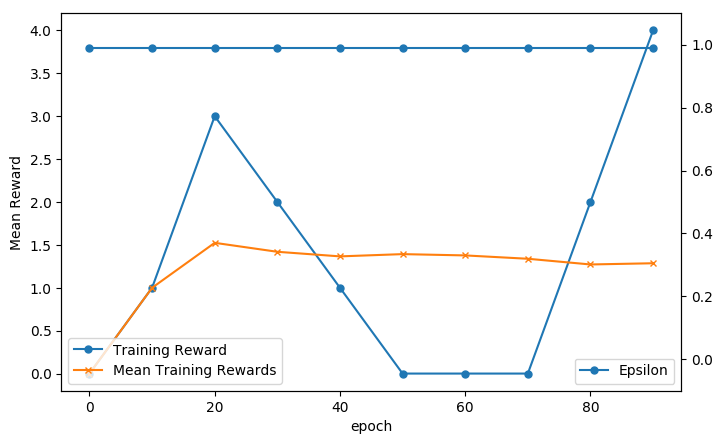

  3% (199 of 5000) |                     | Elapsed Time: 0:40:33 ETA:  22:25:29

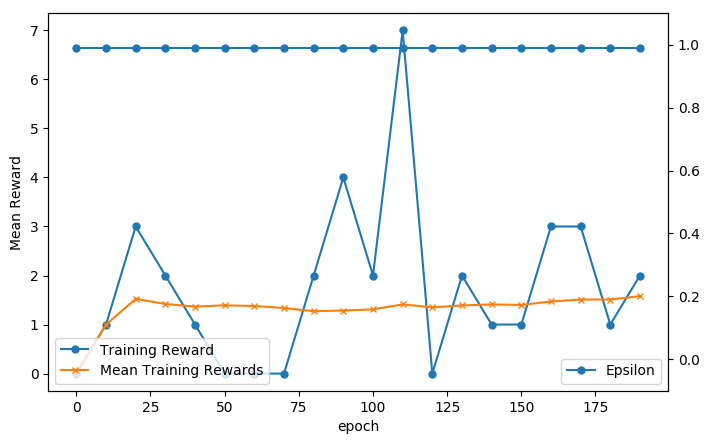

  5% (299 of 5000) |#                    | Elapsed Time: 1:06:53 ETA:  19:33:37

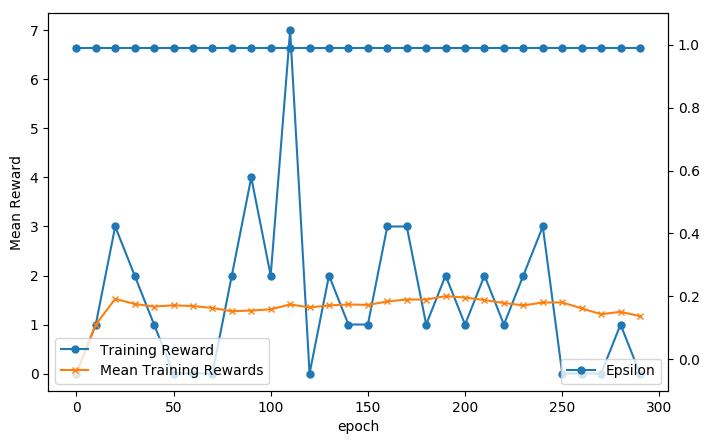

  7% (399 of 5000) |#                    | Elapsed Time: 1:34:08 ETA:  20:46:49

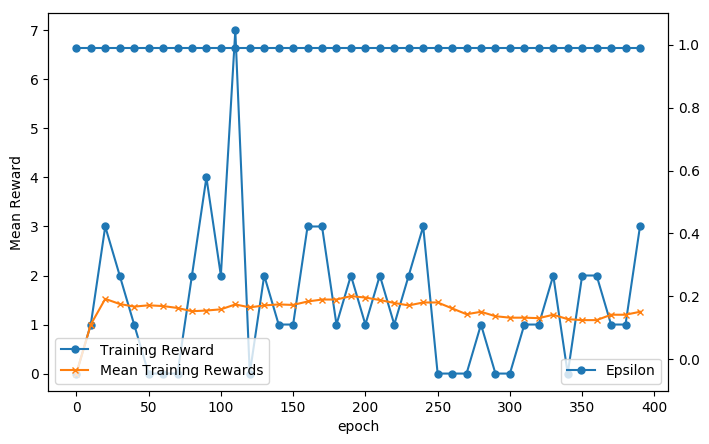

  9% (499 of 5000) |##                   | Elapsed Time: 2:02:04 ETA:  19:40:56

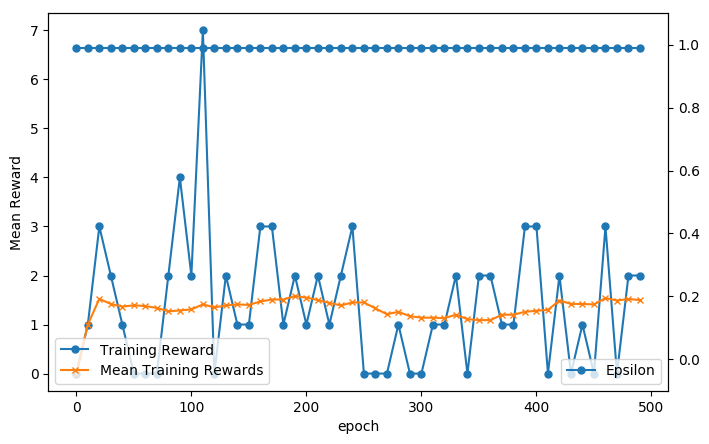

 11% (599 of 5000) |##                   | Elapsed Time: 2:27:28 ETA:  18:30:34

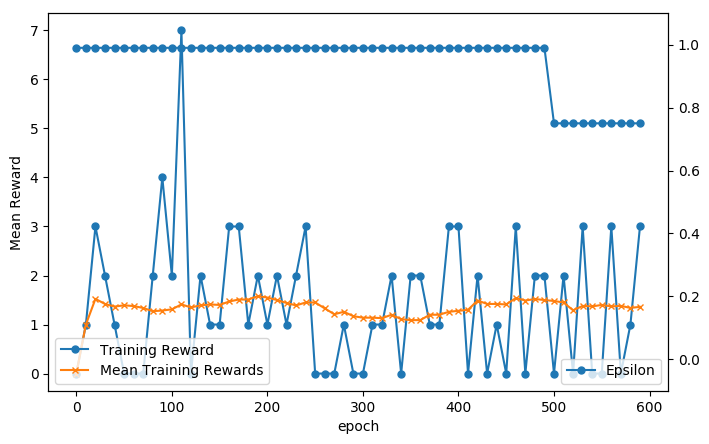

 13% (699 of 5000) |##                   | Elapsed Time: 2:53:37 ETA:  17:31:07

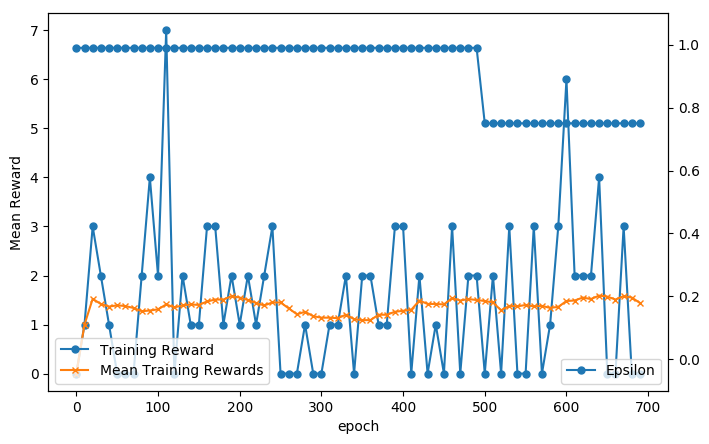

 15% (799 of 5000) |###                  | Elapsed Time: 3:18:22 ETA:  17:26:24

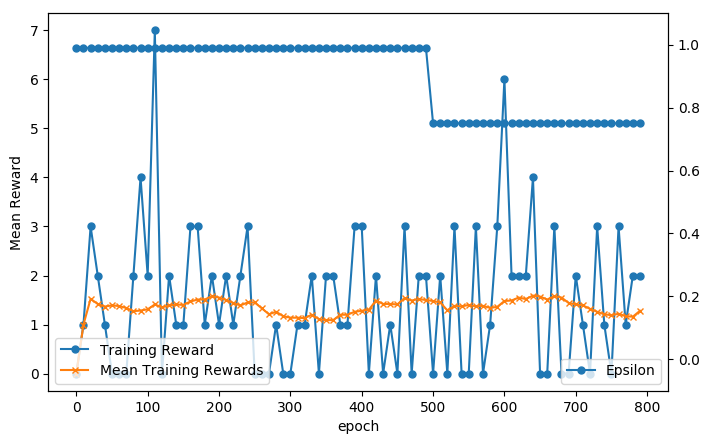

 17% (899 of 5000) |###                  | Elapsed Time: 3:44:20 ETA:  16:58:33

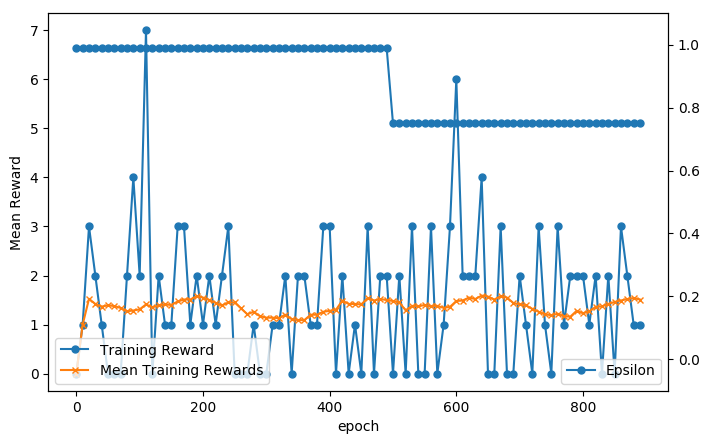

 19% (999 of 5000) |####                 | Elapsed Time: 4:11:18 ETA:  19:00:35

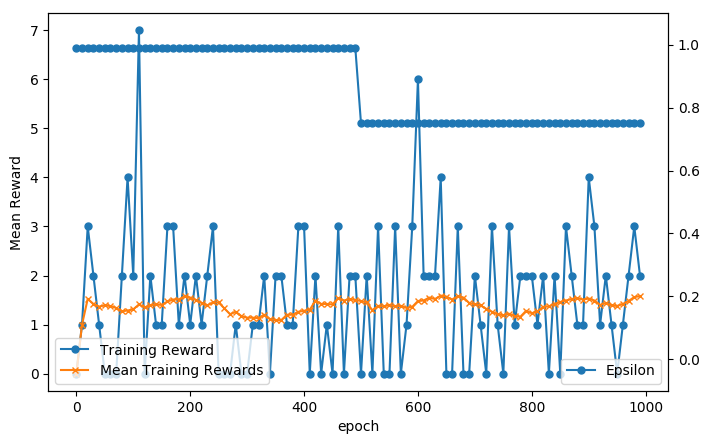

 21% (1099 of 5000) |####                | Elapsed Time: 4:36:13 ETA:  16:16:10

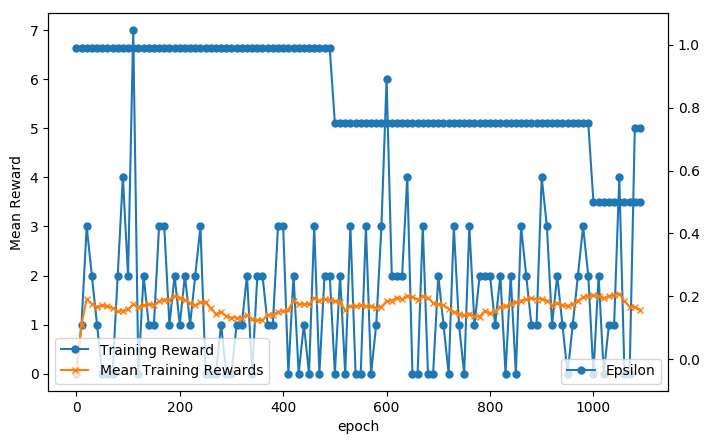

 23% (1199 of 5000) |####                | Elapsed Time: 5:00:44 ETA:  15:25:38

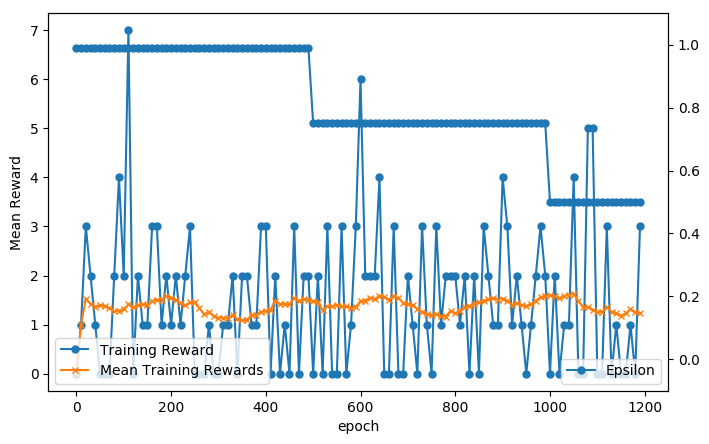

 25% (1299 of 5000) |#####               | Elapsed Time: 5:26:13 ETA:  14:55:58

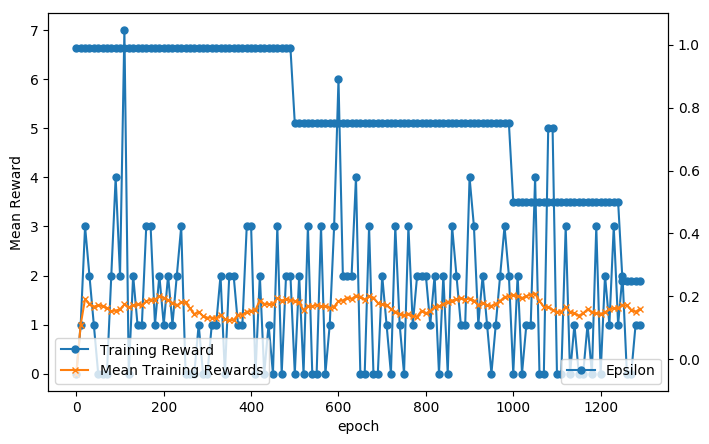

 27% (1399 of 5000) |#####               | Elapsed Time: 5:51:52 ETA:  15:08:37

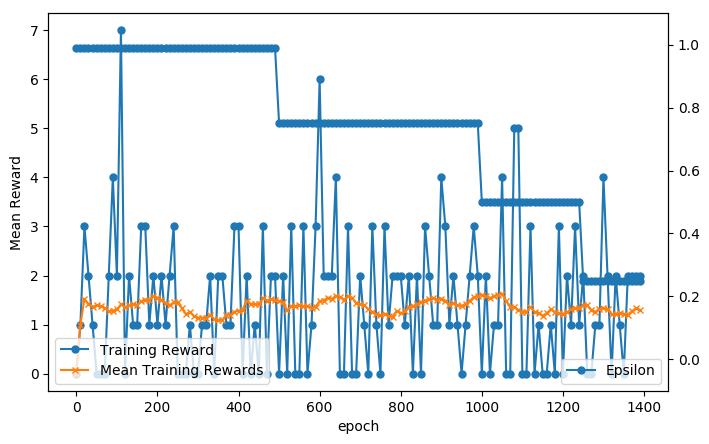

 29% (1499 of 5000) |#####               | Elapsed Time: 6:17:33 ETA:  15:05:31

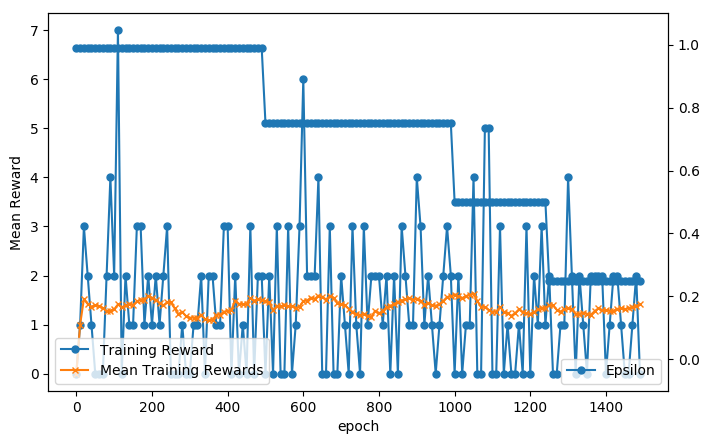

 31% (1599 of 5000) |######              | Elapsed Time: 6:42:47 ETA:  14:39:23

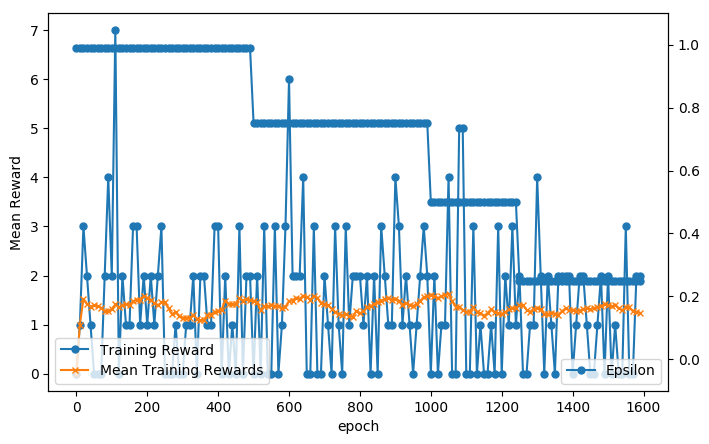

 33% (1699 of 5000) |######              | Elapsed Time: 7:10:08 ETA:  14:30:20

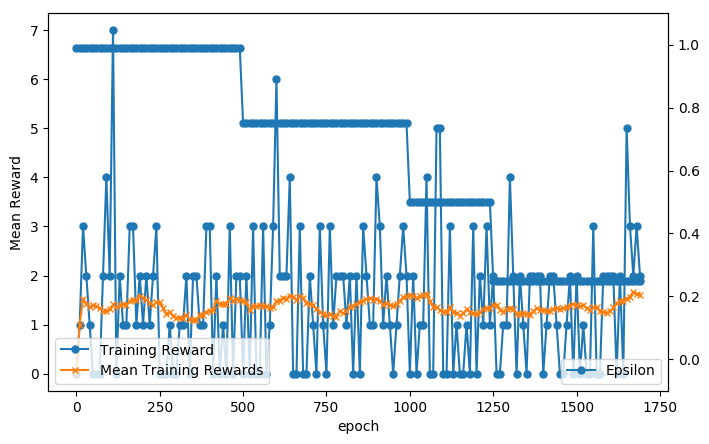

 35% (1799 of 5000) |#######             | Elapsed Time: 7:35:16 ETA:  13:21:34

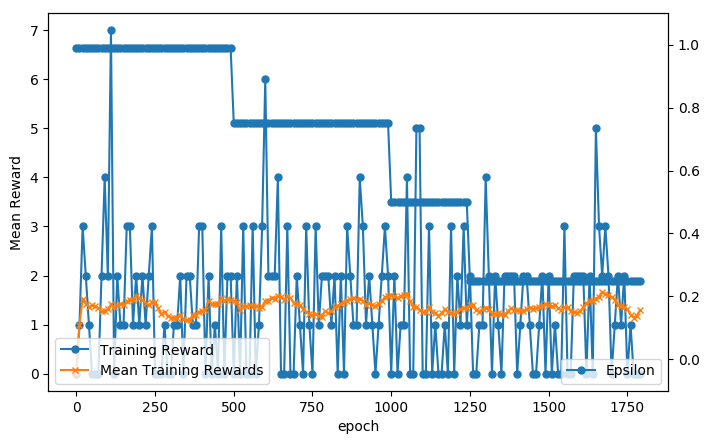

 37% (1899 of 5000) |#######             | Elapsed Time: 7:59:40 ETA:  12:39:12

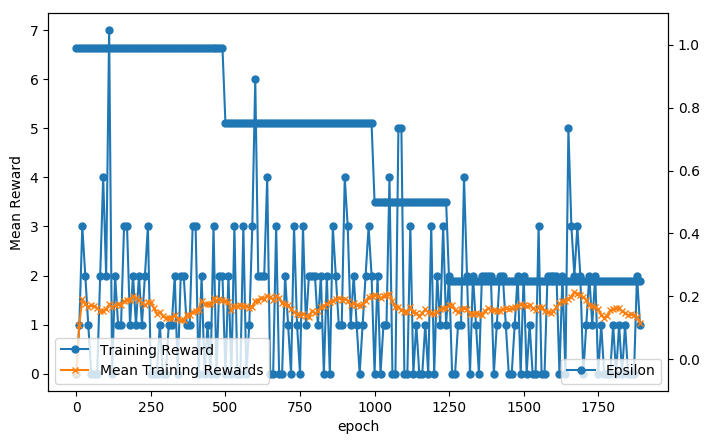

 39% (1999 of 5000) |#######             | Elapsed Time: 8:24:45 ETA:  12:32:22

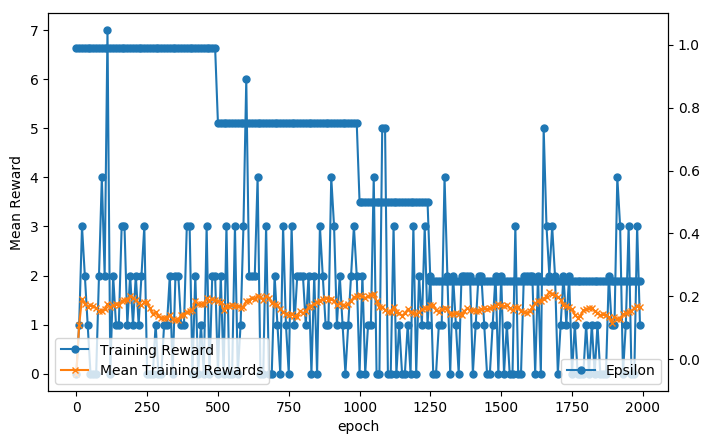

 41% (2099 of 5000) |########            | Elapsed Time: 8:49:55 ETA:  12:19:38

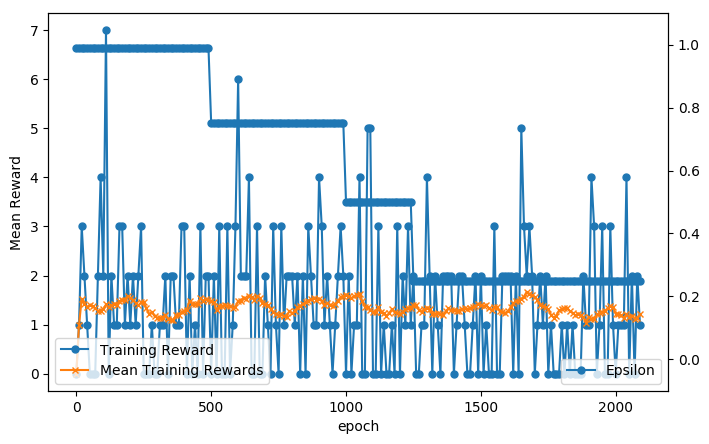

 43% (2199 of 5000) |########            | Elapsed Time: 9:14:26 ETA:  11:13:19

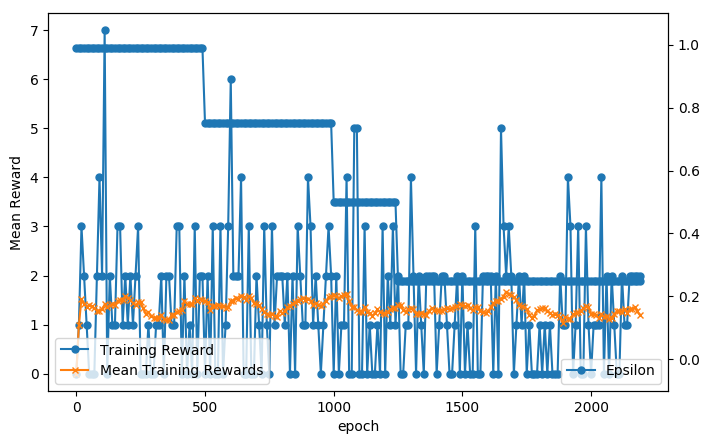

 45% (2299 of 5000) |#########           | Elapsed Time: 9:40:02 ETA:  11:06:01

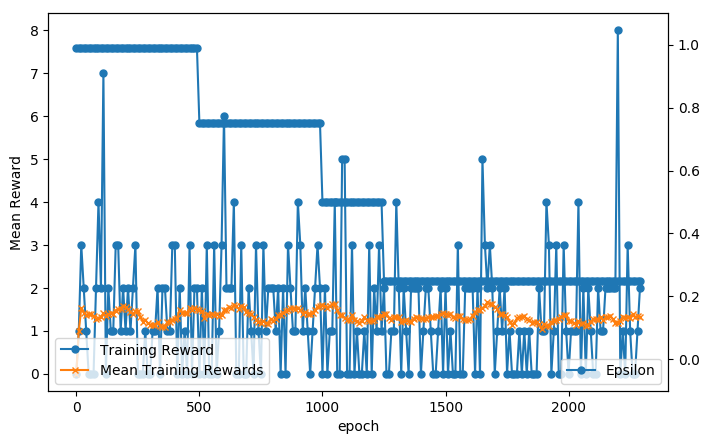

 47% (2399 of 5000) |#########          | Elapsed Time: 10:05:39 ETA:  11:32:31

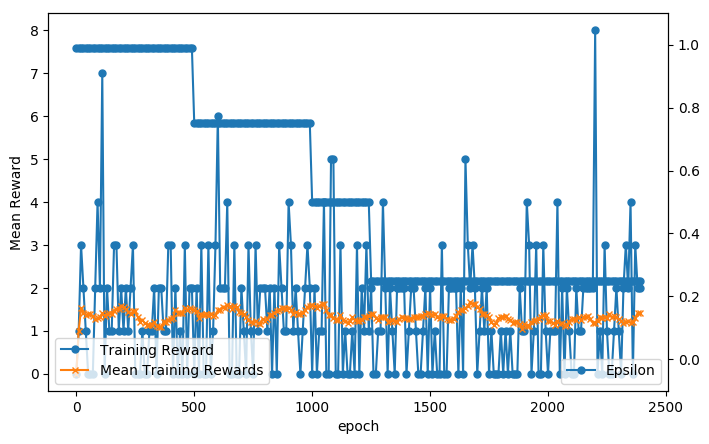

 49% (2499 of 5000) |#########          | Elapsed Time: 10:30:45 ETA:  10:42:26

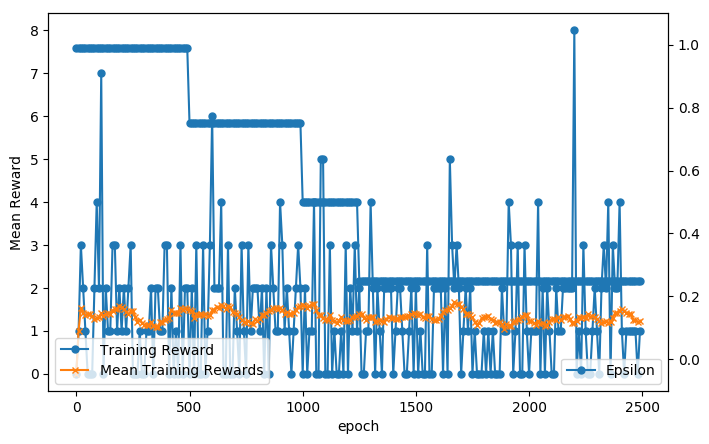

 51% (2599 of 5000) |#########          | Elapsed Time: 10:55:54 ETA:  10:17:12

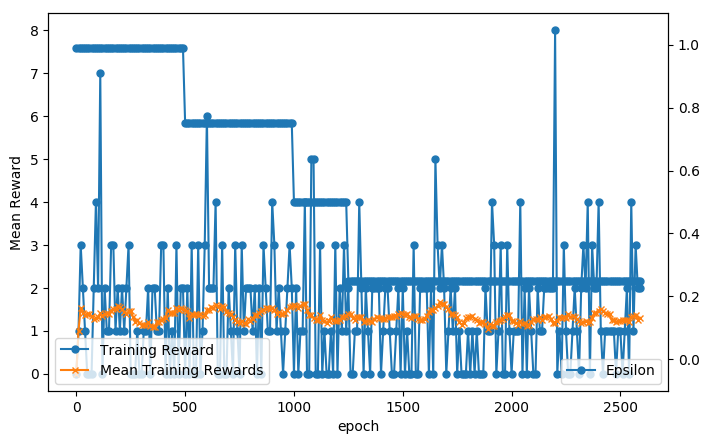

 53% (2699 of 5000) |##########          | Elapsed Time: 11:21:21 ETA:  9:38:07

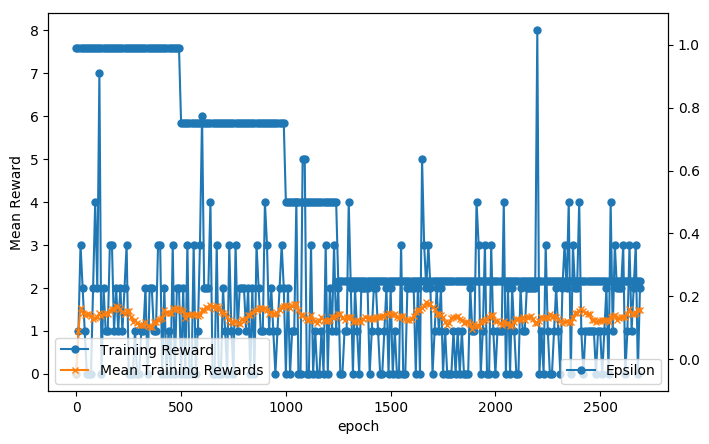

 55% (2799 of 5000) |###########         | Elapsed Time: 11:46:50 ETA:  9:31:38

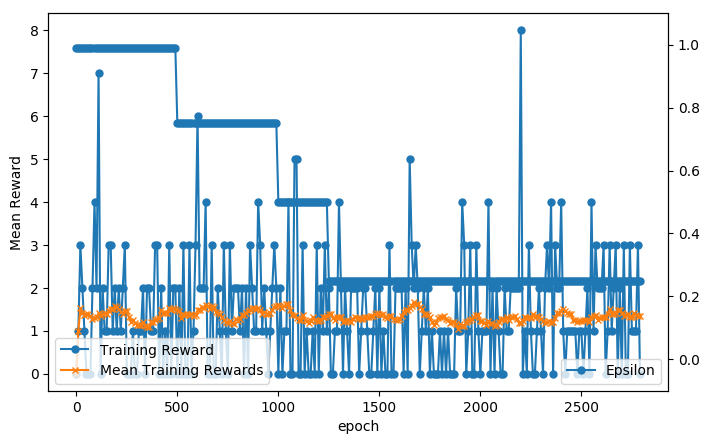

 57% (2899 of 5000) |###########         | Elapsed Time: 12:11:04 ETA:  8:22:05

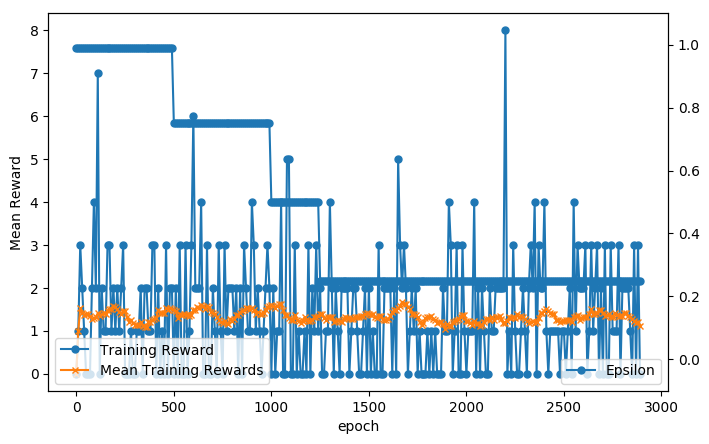

 59% (2999 of 5000) |###########         | Elapsed Time: 12:37:15 ETA:  8:05:34

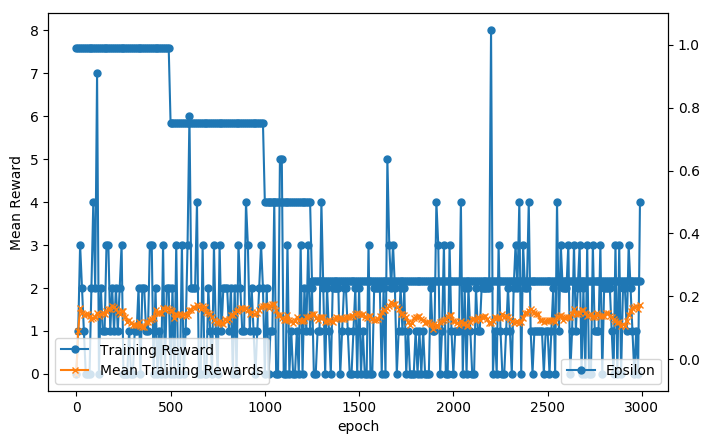

 61% (3099 of 5000) |############        | Elapsed Time: 13:02:25 ETA:  8:05:45

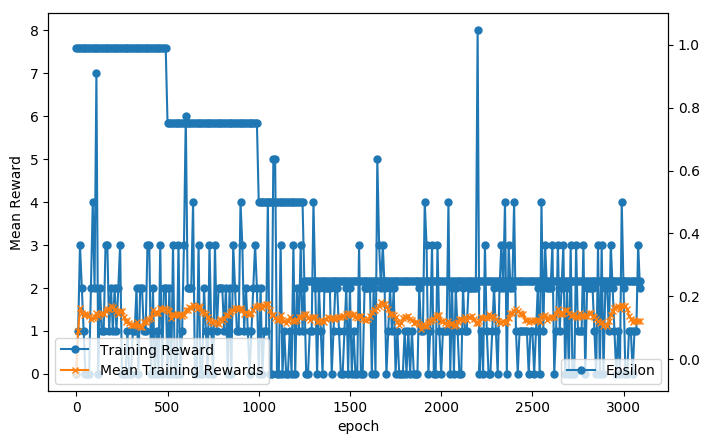

 63% (3199 of 5000) |############        | Elapsed Time: 13:26:46 ETA:  7:00:20

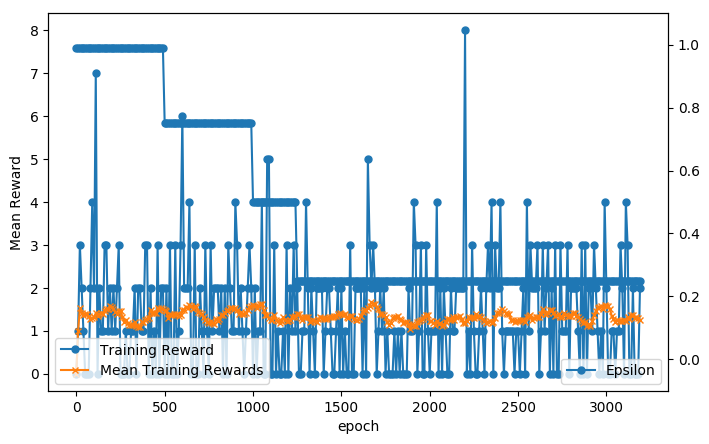

 65% (3299 of 5000) |#############       | Elapsed Time: 13:52:56 ETA:  7:23:28

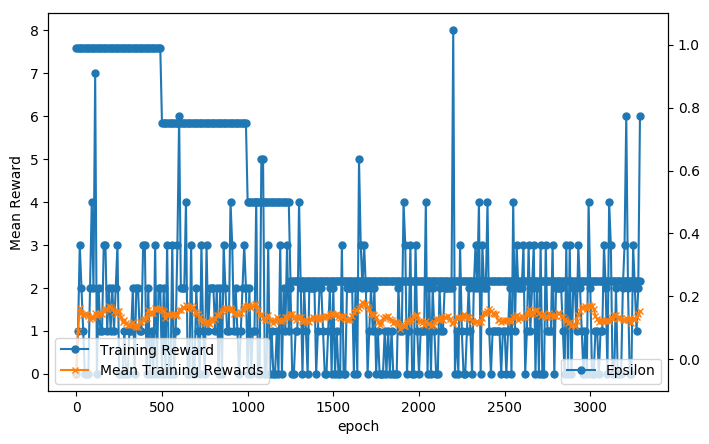

 67% (3399 of 5000) |#############       | Elapsed Time: 14:18:03 ETA:  6:48:54

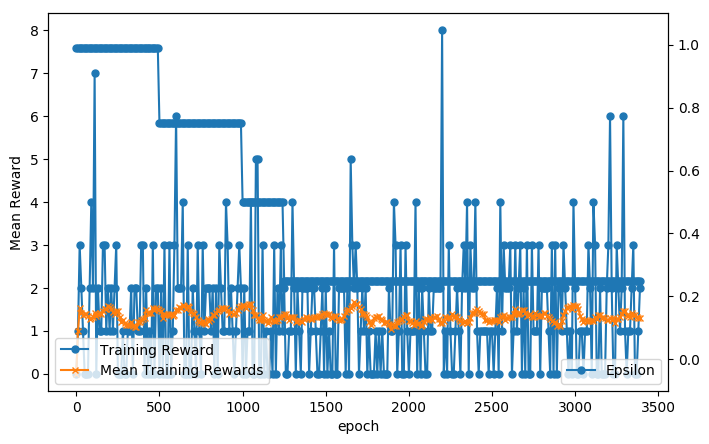

 69% (3499 of 5000) |#############       | Elapsed Time: 14:42:53 ETA:  6:10:27

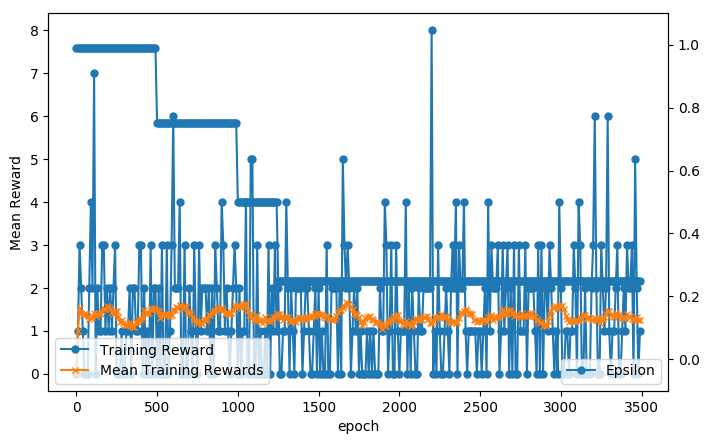

 71% (3599 of 5000) |##############      | Elapsed Time: 15:08:12 ETA:  5:49:21

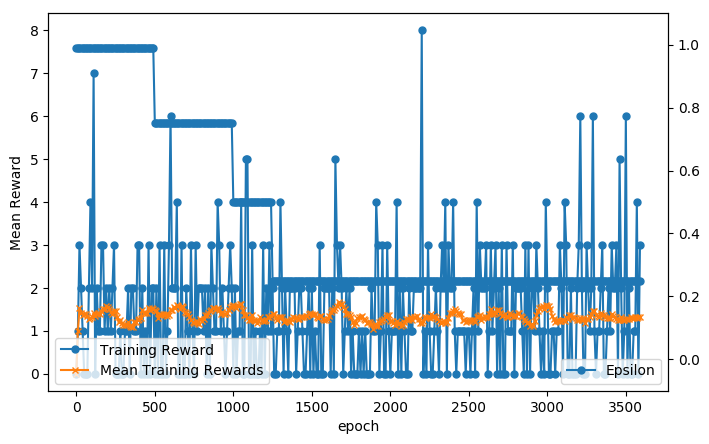

 73% (3699 of 5000) |##############      | Elapsed Time: 15:34:13 ETA:  5:26:31

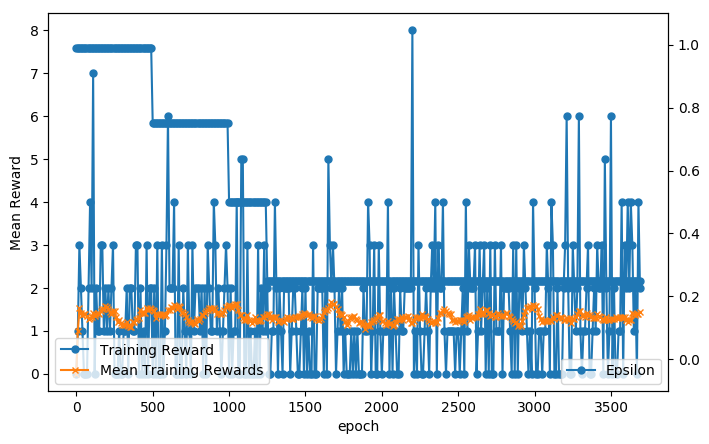

 75% (3799 of 5000) |###############     | Elapsed Time: 15:58:32 ETA:  4:56:30

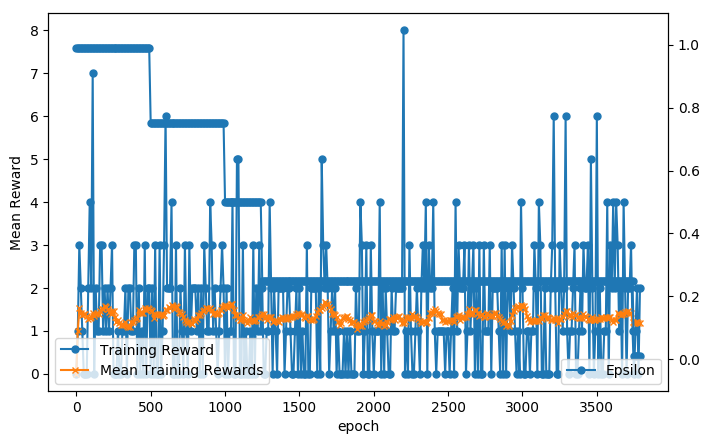

 77% (3899 of 5000) |###############     | Elapsed Time: 16:24:04 ETA:  4:59:25

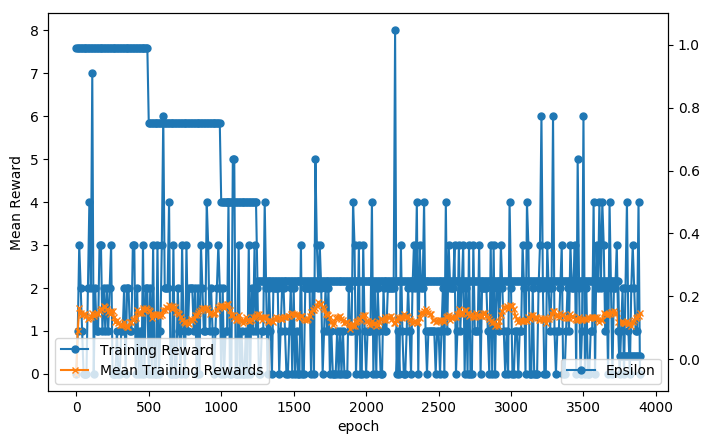

 79% (3999 of 5000) |###############     | Elapsed Time: 16:50:00 ETA:  4:15:34

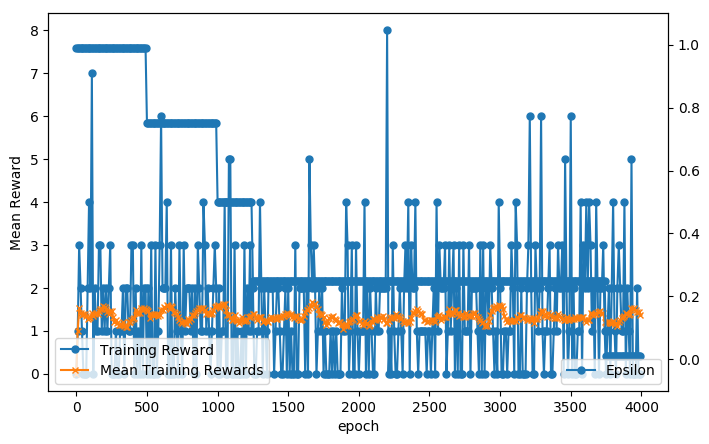

 81% (4099 of 5000) |################    | Elapsed Time: 17:15:17 ETA:  3:46:39

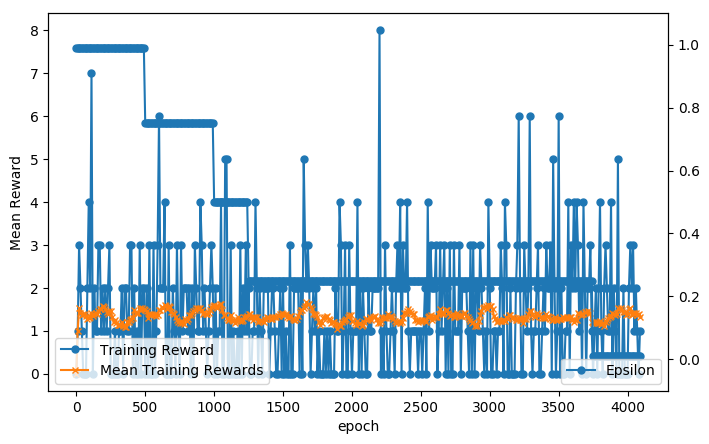

 83% (4199 of 5000) |################    | Elapsed Time: 17:40:37 ETA:  3:14:12

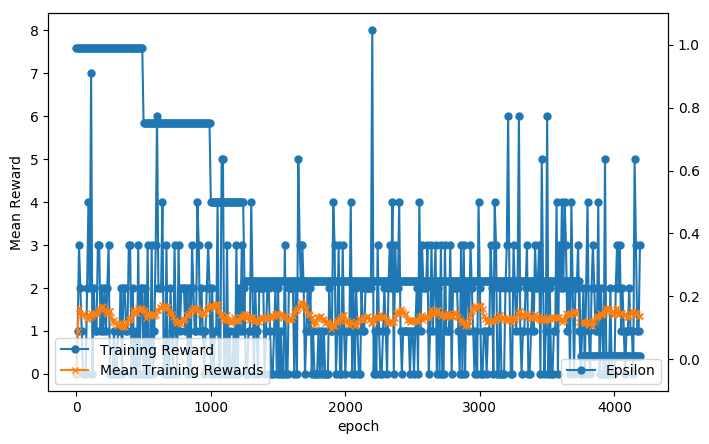

 85% (4299 of 5000) |#################   | Elapsed Time: 18:06:42 ETA:  3:02:05

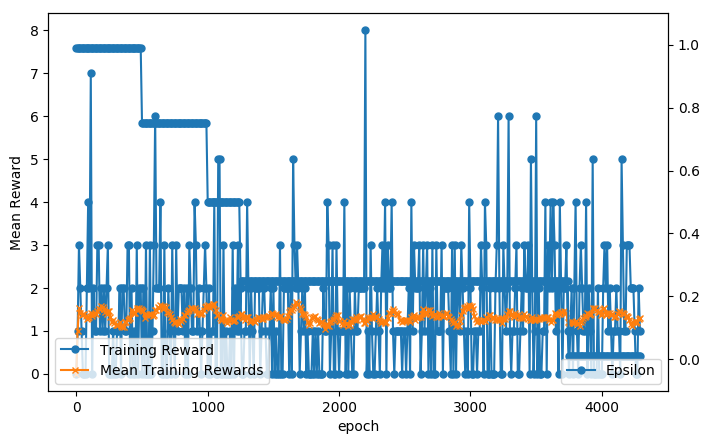

 87% (4399 of 5000) |#################   | Elapsed Time: 18:32:43 ETA:  2:36:17

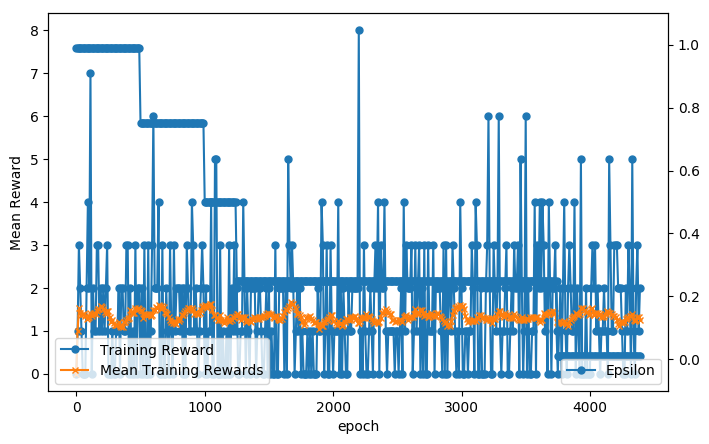

 89% (4499 of 5000) |#################   | Elapsed Time: 19:01:04 ETA:  2:17:47

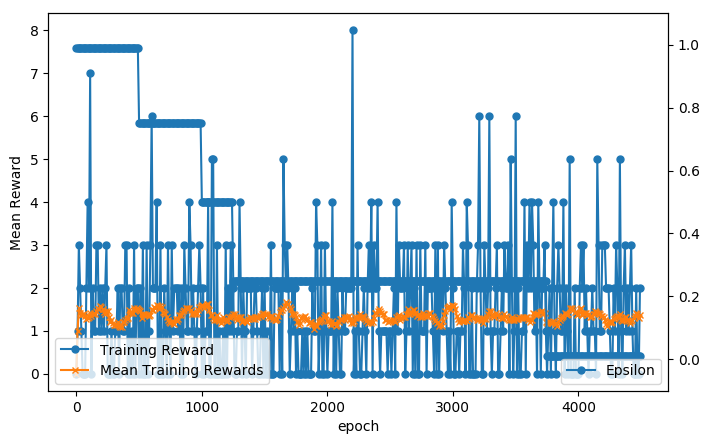

 91% (4599 of 5000) |##################  | Elapsed Time: 19:29:19 ETA:  1:57:50

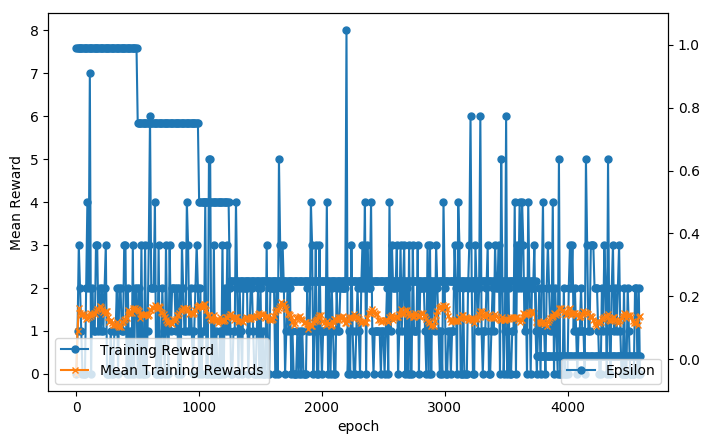

 93% (4699 of 5000) |##################  | Elapsed Time: 19:57:28 ETA:  1:22:06

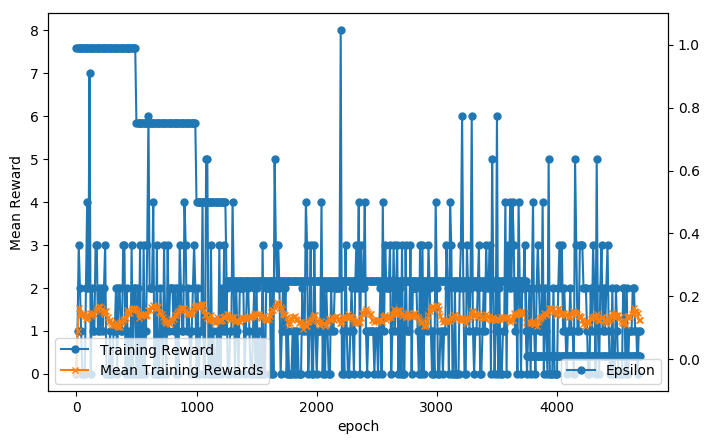

 95% (4799 of 5000) |################### | Elapsed Time: 20:25:12 ETA:  0:55:42

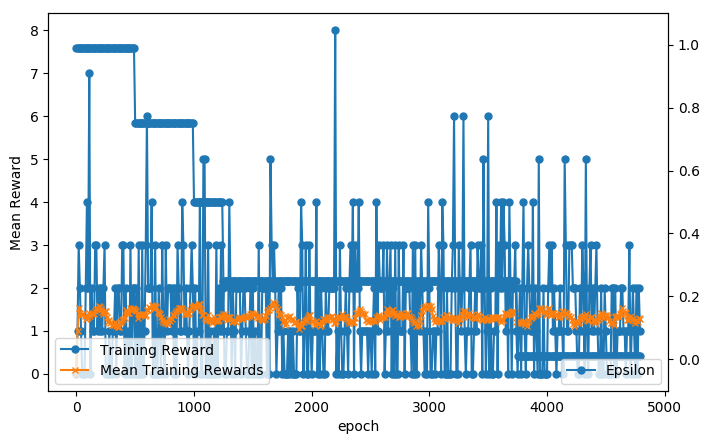

 97% (4899 of 5000) |################### | Elapsed Time: 20:53:41 ETA:  0:29:49

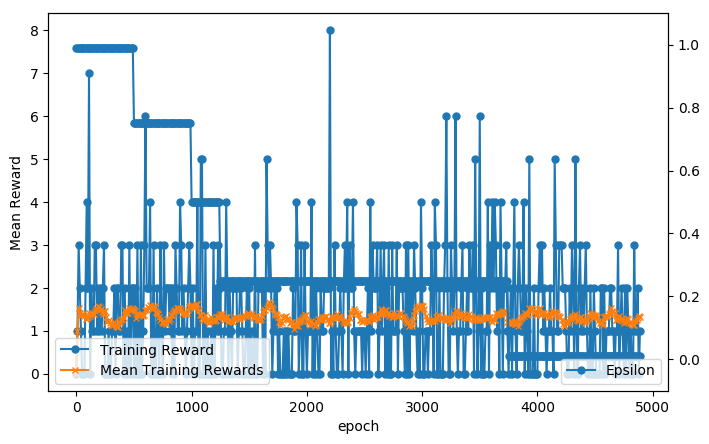

 99% (4999 of 5000) |################### | Elapsed Time: 21:20:31 ETA:  0:00:15

In [ ]:
pbar = ProgressBar()
training_score = []
test_score = []

def time_usage(func):
    def wrapper(*args, **kwargs):
        beg_ts = time.time()
        retval = func(*args, **kwargs)
        end_ts = time.time()
        # print("elapsed time %s: %f" % (func.__name__, end_ts - beg_ts))
        return retval
    return wrapper

def run_episode(epsilon, pool_actions=False, render=True):
    # print("Start Episode: epsilon %s", epsilon)
    moves = 0
    beg_ts = time.time()
    done = False
    frame = env.reset()
    prev_frame = np.zeros_like(frame) # the "prevvious" frame is nothing
    phi_frame = pre_process_frame(frame, prev_frame)

    while not done:
        if np.random.rand() < epsilon:
            action = np.random.randint(action_size)
        else:
            phi_shape = phi_frame.shape
            shaped_frame = phi_frame.reshape(1, phi_shape[0], phi_shape[1], phi_shape[2])
            action = np.argmax(q_net.predict(shaped_frame))

        prime_frame, reward, done, ale_lives = env.step(action)
        phi_prime_frame = pre_process_frame(frame, prime_frame)
        lives = ale_lives['ale.lives']
        done = done or lives == 0

        if render:
            env.render()
            sleep(0.0001)

        yield phi_frame, action, reward, phi_prime_frame, done, lives

        phi_frame = phi_prime_frame
        prev_frame = frame
        frame = prime_frame
        moves += 1

    end_ts = time.time()
    # print("elapsed time run_episode: %s moves %fs" % (moves, end_ts - beg_ts))

weight_updates = 0

# @time_usage
def update_weights():
    # crop memory
    global frame_memory, action_memory, reward_memory, prime_frame_memory, done_memory, weight_updates, replay_index

    memory_sample = random.sample(
        range(0, min(replay_index, max_replay_size)),
        sample_size
    )

    _frame_batch = frame_memory[memory_sample]
    _prime_frame_batch = prime_frame_memory[memory_sample]
    _action_batch = action_memory[memory_sample]
    _reward_batch = reward_memory[memory_sample]
    _done_batch = done_memory[memory_sample]

    _predictions = q_net.predict(_frame_batch)
    _corrections = _predictions.copy()
    _prime_predictions = q_hat_net.predict(_prime_frame_batch)

    for i in range(0, sample_size):
        _done = _done_batch[i]
        _reward = _reward_batch[i]
        _action = _action_batch[i]

        _prime_prediction = _prime_predictions[i]
        if _done:
            _corrections[i, _action] = _reward_batch[i]
        else:
            _corrections[i, _action] = _reward + gamma * np.max(_prime_prediction)
    q_net.train_on_batch(_frame_batch, _corrections)

    if weight_updates % qhat_update_interval == 0:
        # print("updating target")
        q_hat_net.set_weights(q_net.get_weights())
    weight_updates += 1

step = -1
training_started = False

for episode in pbar(range(0, epochs)):
    if episode < epochs / 10:
        epsilon = 0.99
    elif episode < epochs / 4:
        epsilon = 0.75
    elif episode < epochs / 2:
        epsilon = 0.50
    elif episode < 3 * epochs / 4:
        epsilon = 0.25
    else:
        epsilon = 0.01

    training_score = 0

    # for every action in the episode
    for (
        frame,
        action,
        reward,
        prime_frame,
        done,
        lives
    ) in run_episode(.99, pool_actions=True):
        step += 1
        #
        replay_index += 1
        replay_array_index = replay_index % max_replay_size
        frame_memory[replay_array_index] = frame
        prime_frame_memory[replay_array_index] = prime_frame

        # store the other values in tuples
        action_memory[replay_array_index] = action
        reward_memory[replay_array_index] = reward
        done_memory[replay_array_index] = done

        training_score += reward

        # if time do the training
        if step % q_update_interval == 0 and min_replay_size < replay_index:
            if not training_started:
                training_started = True
                # print("Training Started: ", step)
            update_weights()


# #     test the net
#     test_score = 0

#     for (
#         prev_frame,
#         action,
#         reward,
#         frame,
#         done,
#         lives
#     ) in run_episode(0.01, pool_actions=False, render=True):
#         test_score += test_score

    # print("Record metrics")
    training_rewards.append(training_score)
#     rewards.append(test_score)
#     mean_rewards.append(np.mean(rewards[-100:]))
    mean_training_rewards.append(np.mean(training_rewards[-100:]))
    epsilons.append(epsilon)

    # display progress
    if (episode + 1) % chart_interval == 0:
        index_step = 10
        episodes_num = np.arange(0, len(mean_training_rewards))[0::index_step]
        _mean_training_rewards = mean_training_rewards[0::index_step]
#         _mean_rewards = mean_rewards[0::index_step]
#         _rewards = rewards[0::index_step]
        _training_rewards = training_rewards[0::index_step]
        _epsilons = epsilons[0::index_step]
        episode_index = len(mean_training_rewards)

        fig = plt.figure(figsize=(8, 5), dpi=100)
        par1 = fig.subplots()
        par2 = par1.twinx()

        par2.plot(episodes_num, _epsilons, marker='o', markersize=5, label='Epsilon')
        par2.set_ylim(-0.1, 1.1)
        par2.legend(loc='lower right')

        par1.plot(episodes_num, _training_rewards, marker='o', markersize=5, label='Training Reward')
#         par1.plot(episodes_num, _rewards, marker='o', markersize=5, label='Test Reward')
        par1.plot(episodes_num, _mean_training_rewards, marker='x', markersize=5, label='Mean Training Rewards')
#         par1.plot(episodes_num, _mean_rewards, marker='o', markersize=5, label='Mean Test Reward')
        par1.legend(loc='lower left')
        par1.set_xlabel('epoch')
        par1.set_ylabel('Mean Reward')
        plt.pause(0.01)

        # save after charting
        model_file = '%s-%s-%s.weights' % (env_name, alpha, episode)
        q_net.save_weights(model_file)


In [ ]:
model_file = '%s-%s-%s.weights' % (env_name, alpha, episode)
net.save_weights(model_file)
print(model_file)